In [35]:
%matplotlib inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from collections import defaultdict
from scipy import spatial
from Bio import pairwise2
from tqdm import tqdm_notebook

if '../' not in sys.path:
    sys.path.append('../')

from utils import number2patten

plt.style.use('ggplot')

### Load Embeddings

In [36]:
kmer_sizes = np.array([3, 4, 5])
index_offset = np.concatenate(([0], (4**kmer_sizes))).cumsum()

kmer_emb = pickle.load(open('../max5_min3_mers_10padding_64embedding_epoch1_batch66000000.pickle', 'rb'))
print('All:', kmer_emb.shape)

# Get 5-mers
kmer_emb = kmer_emb[index_offset[2]:index_offset[3]]
print('Only 5mers:', kmer_emb.shape)

All: (1344, 64)
Only 5mers: (1024, 64)


### Computing Nedleman-Wunsch Score and Cosine Distance

In [52]:
def get_comb(kmer_size=5):
    num_kmers = 4**kmer_size
    for i in range(0, num_kmers):
        for ii in range(i+1, num_kmers):
            yield i, ii

kmer_size = 5
combinations = (((4**kmer_size)**2) - 4**kmer_size) // 2
global_align_scores = np.zeros(combinations, dtype=np.int8)
cosine_distance = np.zeros(global_align_scores.size)

for i, (num_seq1, num_seq2) in tqdm_notebook(enumerate(get_comb(kmer_size)), total=combinations):
    seq1 = number2patten(num_seq1, kmer_size)
    seq2 = number2patten(num_seq2, kmer_size)
    global_align_scores[i] = max([align[2] for align in pairwise2.align.globalxx(seq1, seq2)])
    cosine_distance[i] = spatial.distance.cosine(kmer_emb[num_seq1], kmer_emb[num_seq2])

In [53]:
# Saving vectors to file.
np.save('global_align_scores_{}-mers'.format(kmer_size), global_align_scores)
np.save('cosine_distance_{}-mers'.format(kmer_size), cosine_distance)

In [38]:
# Load vectors from file.
global_align_scores = np.load('global_align_scores_{}-mers.npy'.format(kmer_size))
cosine_distance = np.load('cosine_distance_{}-mers.npy'.format(kmer_size))

In [54]:
box_data = defaultdict(list)
for a, b in zip(global_align_scores, cosine_distance):
    box_data[a].append(b)

In [79]:
box_data_labels = sorted(box_data.keys())
box_data_lists = [box_data[d] for d in box_data_labels]

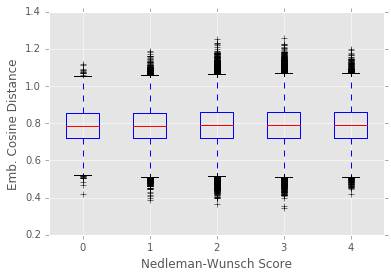

In [80]:
plt.boxplot(box_data_list, labels=box_data_labels)
plt.xlabel('Nedleman-Wunsch Score')
plt.ylabel('Emb. Cosine Distance')
plt.show()